In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from typing import TypedDict, Literal
from dotenv import load_dotenv

d:\Data Science\Project\LLMs\LangChain Models\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
model = ChatGoogleGenerativeAI(model = "gemini-2.0-flash")

In [4]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'negative'] = Field(description='Sentiment of the review')

In [5]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappoianted", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [6]:
structured_model_1 = model.with_structured_output(SentimentSchema)
structured_model_2 = model.with_structured_output(DiagnosisSchema)

In [7]:
prompt = 'What is the sentiment of the following review - The software too good'
structured_model_1.invoke(prompt).sentiment

'positive'

In [8]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [16]:
# Define functions

# Sentiment function
def find_sentiment(state: ReviewState):

    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model_1.invoke(prompt).sentiment

    return {'sentiment': sentiment}


# Check sentiment function
def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:

    if state['sentiment'] == 'positive':
        return 'positive_response'

    else:
        return 'run_diagnosis'
    

# Positive response function
def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response': response}

# Run diagnosis function
def run_diagnosis(state:ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model_2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

# Negative response function
def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

In [17]:
# Define graph

graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)


graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)


workflow = graph.compile()

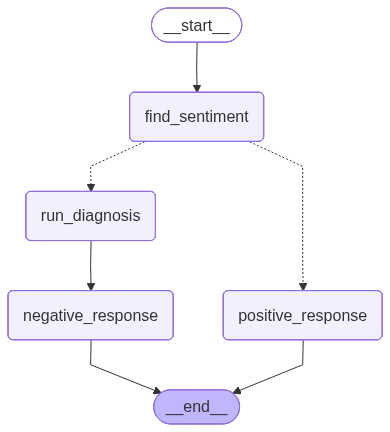

In [18]:
workflow

In [23]:
intial_state={
    'review': "It hasn't got that shining colour and it's black in colour. I would say the product is worth it's price and is very good. It is an amazing product worth buying.😄😄😄"
}
workflow.invoke(intial_state)

{'review': "It hasn't got that shining colour and it's black in colour. I would say the product is worth it's price and is very good. It is an amazing product worth buying.😄😄😄",
 'sentiment': 'positive',
 'response': "Subject: Thank you for your review!\n\nHi there!\n\nThank you so much for taking the time to leave us a review! We really appreciate you saying that the product is worth the price and amazing to buy. We're glad you're enjoying it!\n\nWe understand your comment about the color. We always strive to accurately represent our products, and your feedback is valuable. \n\nIf you have a moment, we'd love for you to leave this feedback (and any other thoughts you have!) directly on our website at [Insert Website Link Here]. This helps other customers and allows us to continue improving our products and service.\n\nThanks again for your support!\n\nSincerely,\n\nThe [Your Company Name] Team"}